In [1]:
import numpy as np 
import matplotlib.pyplot as plt

import torch

import programs.conditions as cnd
import programs.NN as NN
import programs.visualize as vis
import programs.solvers as solv

In [2]:
torch.manual_seed(1234)
np.random.seed(1234)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Gap width
w = 1

# Proppant viscosity
mu0 = 1

# Maximum proppant concentration
cmax = 1

# Influent proppant concentration
cin = 0.5

# Incoming flow rate
v_x_inlet = -0.025

# Mixture flow
Q0 = -v_x_inlet*w

# Length of permeable area
chi = 0.4

# Width
H = 1

# Length
L = 1

# Number of randomly generated points for IC and BC
num_points = 32000 

# Bounds for t,x,y
x_min, x_max, y_min, y_max, t_min, t_max = 0, L, 0, H, 0, 10
boundaries = [x_min, x_max, y_min, y_max, t_min, t_max]

# Coordinates for IC and BC
x_range, y_range, t_range = np.random.uniform(x_min, x_max, num_points), np.random.uniform(y_min, y_max, num_points), np.random.uniform(t_min, t_max, num_points)
ranges = [x_range, y_range, t_range]

# Number of collocation points
collocation = 32

# Function describing the distribution of mixture flow along the perforation interval
psi = np.where(np.abs(y_range - np.max(y_range) / 2) <= chi / 2, 1 / chi, 0)

zeros = np.zeros(num_points)
ones = np.ones(num_points)

c_condition = [[zeros, zeros, zeros, cin * psi * chi], [1, 1, 0, 0]]
cond = np.round(12 * mu0 * Q0 * psi / np.power(w, 3), 5)
p_condition = [[zeros, zeros, cond, cond], [1, 1, 1, 1]]
print (np.max(c_condition[0]), np.max(cond), collocation**3)

0.5 0.75 32768


In [4]:
net = NN.Poisson_Convection(w=w, mu0=mu0, cmax=cmax, v_in=v_x_inlet, chi=chi, size=boundaries,
                            c_cond=c_condition, p_cond=p_condition, collocation=collocation, ranges=ranges)

C:\Users\ilya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3550.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# net.full_save("data/wtf4","data/wtf4d")
# net.full_load("data/wtf4","data/wtf4d.npy")
# net.full_load("data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05","data/CL_v_in,[0.05, 0.1, 0.2, 0.5, 1]/0.05_data.npy")

In [6]:
net.weights = [1,1,1,1]
net.Adam_epochs = 5000
net.train()
# net.full_save("data/vx=0.025chi=0.4hmm2","data/vx=0.025chi=0.4hmm2d")
# parameters = {'v_in':[0.05, 0.1, 0.2, 0.5, 1]}
# net.CL_train(constants=parameters)
# net.full_save("data/vx=0.05chi=0.4","data/vx=0.05chi=0.4d")

|       Epochs        |           PDE loss            |            IC loss            |            BC loss            |         Summary loss          |
|          0          |     8.446740685030818e-05     |      0.0628056675195694       |      0.14793778955936432      |      0.21082791686058044      |
|         10          |     9.94187721516937e-05      |      0.02498738467693329      |      0.13067501783370972      |      0.15576182305812836      |
|         20          |     0.0002674103598110378     |     0.0035864687524735928     |      0.12180142104625702      |      0.12565529346466064      |
|         30          |     0.0009009996429085732     |    0.00020653681713156402     |      0.11152441799640656      |      0.11263195425271988      |
|         40          |     0.0022678044624626637     |    0.00012641982175409794     |      0.09643159061670303      |      0.09882581233978271      |
|         50          |     0.0019005787326022983     |     0.0007197377271950245     | 

0.043486978858709335 5028


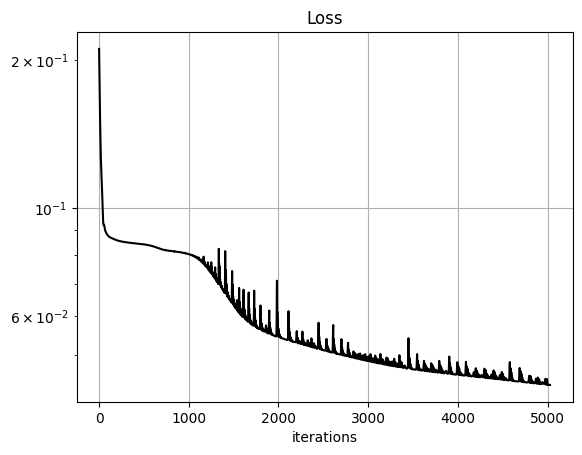

In [7]:
print (net.losses[-1], len(net.losses))
plt.semilogy(net.losses, c='black')
plt.title('Loss')
plt.xlabel('iterations')
plt.grid()
# plt.ylim(0,1)

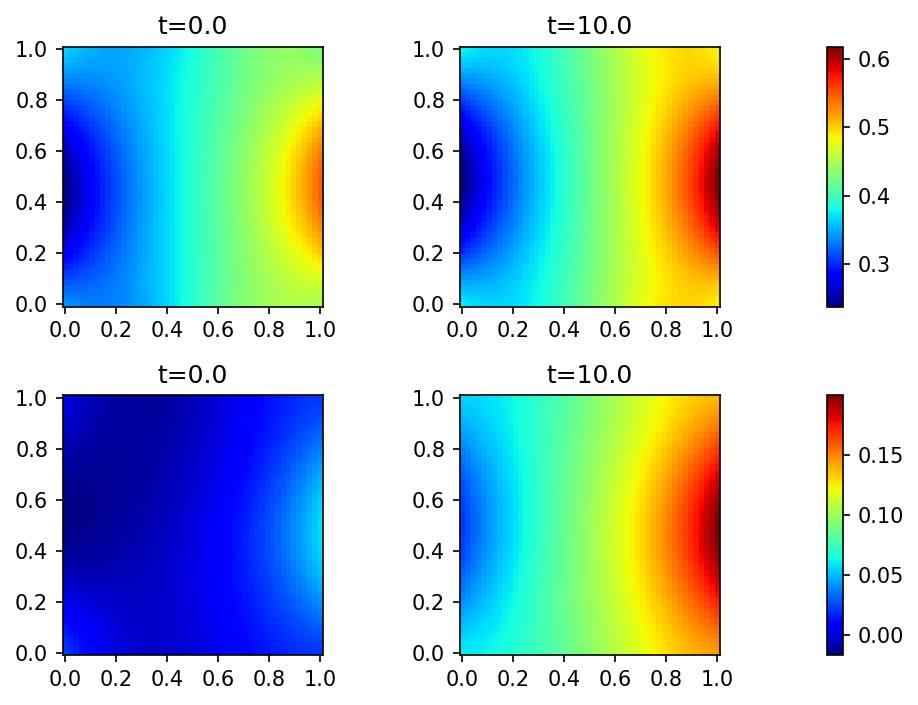

In [8]:
Nx = 49
Ny = 49
outputs = vis.plot_results(x_min, x_max, y_min, y_max, t_max, net.model, Nx, Ny)

In [9]:
solver = solv.Solver(net.mu0, cmax, cin, chi, Q0, w, H, L, Nx, Ny)
solver.load(['solve/c0.02504.npy','solve/p0.02504.npy','solve/t0.02504.npy'])

In [10]:
# solver.Transport_Solver(10)
# solver.save(['solve/c0.02504.npy','solve/p0.02504.npy','solve/t0.02504.npy'])

0.75


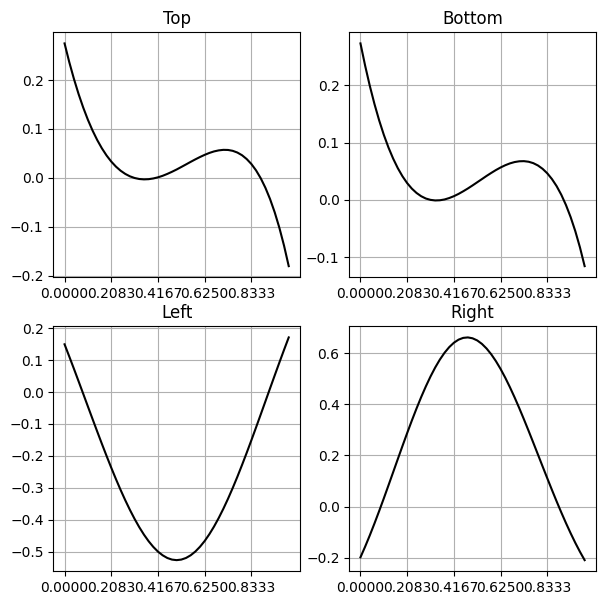

In [18]:
x = np.linspace(x_min, x_max, Nx)
y = np.linspace(y_min, y_max, Ny)
X, Y = np.meshgrid(x,y)
K = 200
p_analitical = cnd.Poisson_analytical(mu=mu0, Q0=Q0, w=w, x=X, y=Y, chi=chi, H=H, L=L, K=K)
vis.plot_BC(outputs[1], x, y, L/(Nx-1), H/(Ny-1), [1,1,1,1])
print (np.max(cond))
# plt.plot(y, np.where(np.abs(y - np.max(y) / 2) <= chi / 2, np.max(cond), 0))
# plt.plot(x,outputs[2][:,-1])
# print ((L/(Nx-1)))

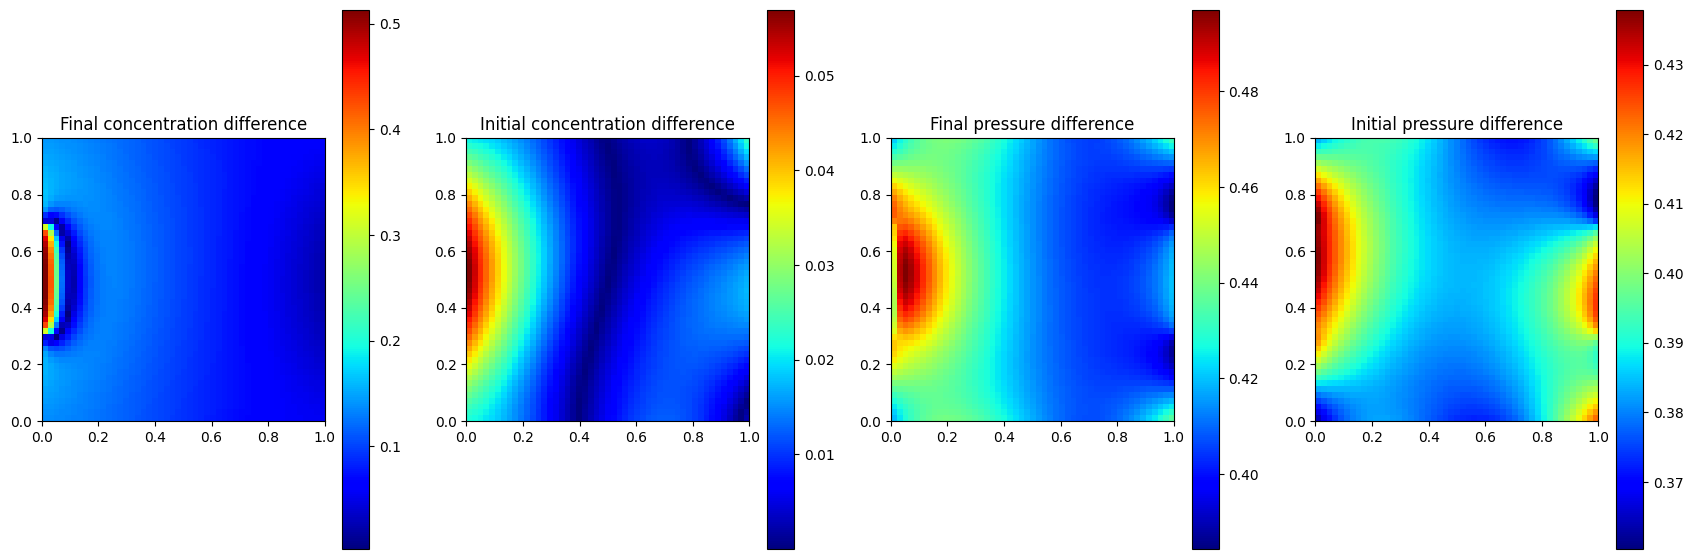

In [16]:
fig = plt.figure(figsize=(21,7))
plt.subplot(141)
vis.plot(np.abs(solver.c[-1][1:-1,1:-1] - outputs[3][:,::-1]), [x_min,x_max,y_min,y_max], 'Final concentration difference')
plt.subplot(142)
vis.plot(np.abs(solver.c[0][1:-1,1:-1] - outputs[2][:,::-1]), [x_min,x_max,y_min,y_max], 'Initial concentration difference')
plt.subplot(143)
vis.plot(np.abs(solver.p[-1][1:-1,1:-1] - outputs[1][:,::-1]), [x_min,x_max,y_min,y_max], 'Final pressure difference')
plt.subplot(144)
vis.plot(np.abs(solver.p[0][1:-1,1:-1] - outputs[0][:,::-1]), [x_min,x_max,y_min,y_max], "Initial pressure difference")

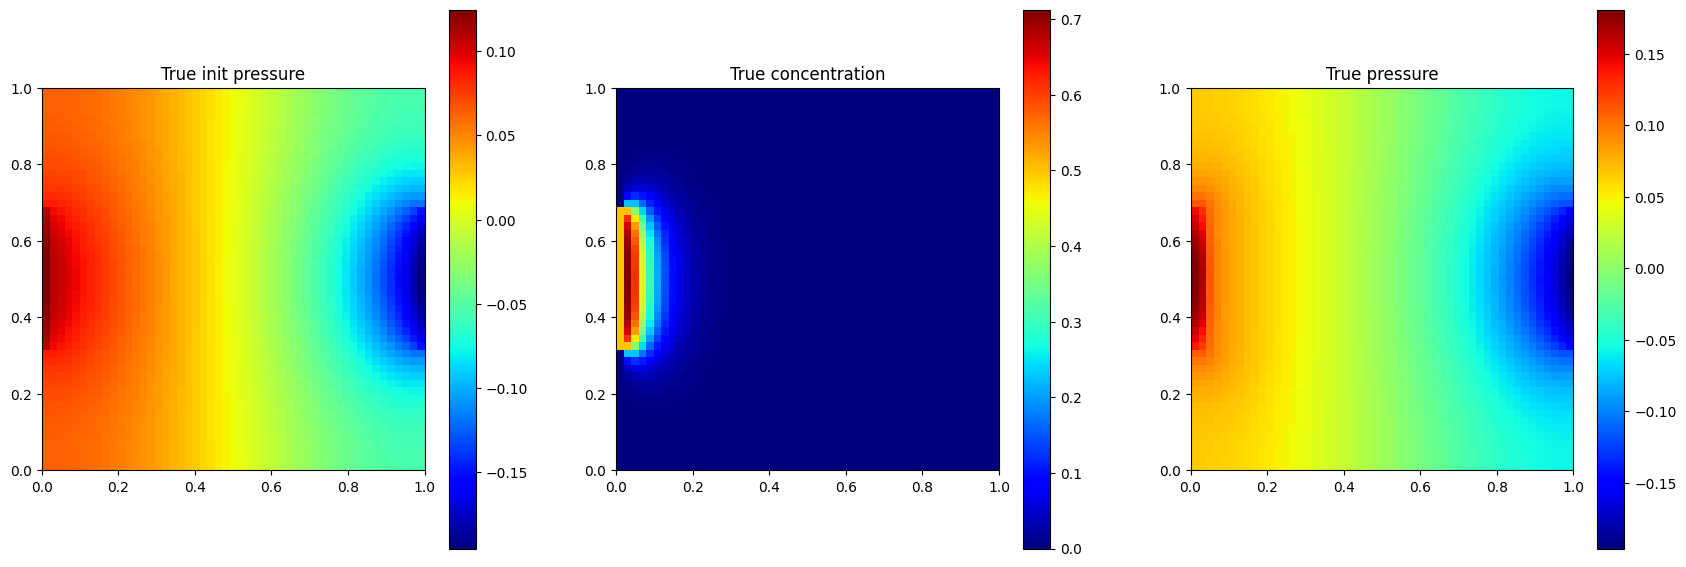

In [17]:
fig = plt.figure(figsize=(21,7))
plt.subplot(131)
vis.plot(solver.p[0], [x_min,x_max,y_min,y_max], 'True init pressure')
plt.subplot(132)
vis.plot(solver.c[-1], [x_min,x_max,y_min,y_max], 'True concentration')
plt.subplot(133)
vis.plot(solver.p[-1], [x_min,x_max,y_min,y_max], 'True pressure')